# Overfitting demo

## Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [134]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

%matplotlib inline

Create random values for x in interval [0,1)

In [135]:
random.seed(98103)
n = 30
x = np.array([random.random() for i in range(n)])
x.sort()
x

array([0.03957894, 0.0415681 , 0.07243195, 0.15028904, 0.16133414,
       0.19195631, 0.23283392, 0.25990098, 0.38014581, 0.43244472,
       0.47056698, 0.4714946 , 0.4787064 , 0.49053554, 0.54678006,
       0.56968036, 0.60793245, 0.62023754, 0.63009313, 0.64500967,
       0.6467576 , 0.69908978, 0.79024505, 0.81038465, 0.82932089,
       0.85011156, 0.88636844, 0.89114108, 0.90438848, 0.92448587])

Compute y

In [136]:
y = np.sin(4*x)
y

array([ 0.15765527,  0.16550732,  0.28569137,  0.56559633,  0.60146736,
        0.69457232,  0.80241773,  0.86220366,  0.99873959,  0.98738887,
        0.95188361,  0.95073995,  0.9414033 ,  0.92439655,  0.81600889,
        0.75971273,  0.65172975,  0.6136243 ,  0.58202776,  0.53250217,
        0.52657119,  0.33841644, -0.01938632, -0.09977964, -0.17478847,
       -0.25597249, -0.39299012, -0.41047204, -0.45819309, -0.52809088])

Add random Gaussian noise to y

In [137]:
random.seed(1)
e = np.array([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e
y

array([ 0.58705019,  0.64865585,  0.30780331,  0.31074845,  0.23740963,
        0.70501716,  0.46171668,  0.38326051,  1.06517691,  1.03184707,
        1.13403971,  0.64608297,  0.94307173,  0.90281597,  0.31406589,
        0.93904512,  0.75863345,  1.40999498,  0.64968415,  0.48426807,
        0.93749025,  0.40468019,  0.28362402, -0.22162773, -0.10206453,
        0.08545707, -0.16090778, -0.36764796, -0.81896243, -0.37968362])

### Put data into a dataframe to manipulate later

In [138]:
data = pd.DataFrame({'X1': x, 'Y': y})
data.head()

,X1,Y
0,0.039579,0.587050
1,0.041568,0.648656
2,0.072432,0.307803
3,0.150289,0.310748
4,0.161334,0.237410


### Create a function to plot the data, since we'll do it many times

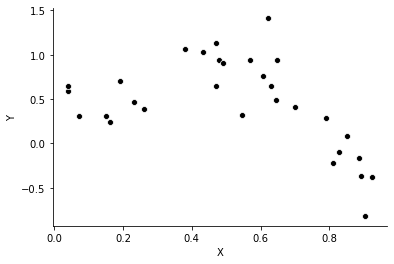

In [139]:
def plot_data(data):
    sns.scatterplot(data=data, x="X1", y="Y", color='black')
    plt.xlabel("X")
    sns.despine()

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [140]:
def polynomial_features(data, deg):
    data_copy = data.copy()
    for i in range(1, deg):
        data_copy['X'+str(i+1)] = data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

# example: adding columns for x^2 and x^3
polynomial_features(data, 3).head()

,X1,Y,X2,X3
0,0.039579,0.587050,0.001566,0.000062
1,0.041568,0.648656,0.001728,0.000072
2,0.072432,0.307803,0.005246,0.000380
3,0.150289,0.310748,0.022587,0.003395
4,0.161334,0.237410,0.026029,0.004199


Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [141]:
def polynomial_regression(data, deg):
    X = polynomial_features(data, deg).drop('Y', axis=1)
    X = sm.add_constant(X)
    y = data['Y']
    
    model = sm.OLS(y, X).fit()
    
    return model

Define a function to plot data and predictions made, since we are going to use it many times.

In [142]:
def plot_poly_predictions(data, model):
    plot_data(data)
    
    # get the degree of the polynomial
    deg = len(model.params)-1
    
    # create 200 points in the x-axis and compute the predicted value for each point
    X_pred = pd.DataFrame({'X1': [i/200.0 for i in range(200)]})
    X_new = polynomial_features(X_pred, deg)
    X_new = sm.add_constant(X_new)
    y_pred = model.predict(X_new)

    # plot the predictions
    plot_data(data)
    ax = sns.lineplot(X_pred['X1'], y_pred, color='seagreen')
    plt.ylabel('Y')
    ax.text(X_pred['X1'].min(), np.max(data['Y']), 'degree '+str(deg)+' fit', fontweight='semibold')
    sns.despine()

Create a function that prints the polynomial coefficients in a pretty way :)

In [143]:
def print_coefficients(model):    
    # get the degree of the polynomial
    deg = len(model.params)-1

    # get the fitted parameters as a list
    w = model.params.tolist()

    # numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print('Fitted polynomial for degree '+str(deg)+':')
    print(np.poly1d(w[::-1]))

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [144]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [145]:
print_coefficients(model)

Fitted polynomial for degree 2:
        2
-5.129 x + 4.147 x + 0.07471


Form and plot our predictions along a grid of x values:

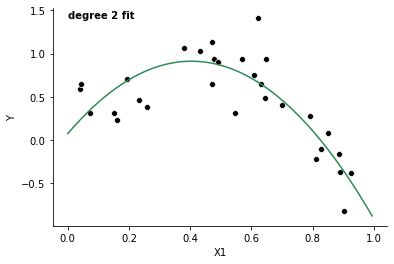

In [146]:
plot_poly_predictions(data, model)

## Fit a degree-4 polynomial

Fitted polynomial for degree 4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


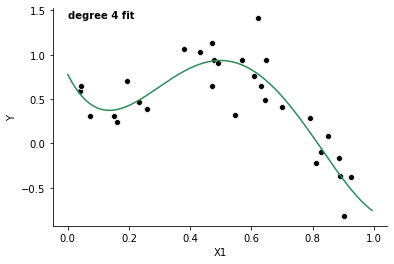

In [147]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data, model)

## Fit a degree-16 polynomial

In [148]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Fitted polynomial for degree 16:
           16             15             14             13
3.337e+08 x  - 2.226e+09 x  + 6.621e+09 x  - 1.156e+10 x 
              12         11             10             9            8
 + 1.309e+10 x  - 1e+10 x  + 5.141e+09 x  - 1.658e+09 x + 2.26e+08 x
              7             6             5             4             3
 + 6.686e+07 x - 4.732e+07 x + 1.393e+07 x - 2.547e+06 x + 3.017e+05 x
              2
 - 2.187e+04 x + 839.3 x - 12.01


### Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

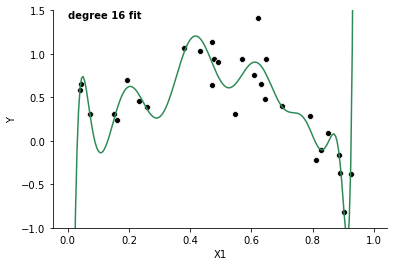

In [149]:
plot_poly_predictions(data, model)
# adjust the y-axis limits
plt.ylim(-1.0, 1.5);

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controlled by a parameter lambda.

Define a function to solve the ridge objective for a polynomial regression model of any degree:

In [150]:
def polynomial_ridge_regression(data, deg, alpha):
    X = polynomial_features(data, deg).drop('Y', axis=1)
    X = sm.add_constant(X)
    y = data['Y']
    
    # the term "alpha" is used instead of "lambda" in statsmodels (and sklearn btw)
    model = sm.OLS(y, X).fit_regularized(alpha=alpha, L1_wt=0.0)

    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [151]:
model = polynomial_ridge_regression(data, deg=16, alpha=1e-25)
print_coefficients(model)

Fitted polynomial for degree 16:
           16             15             14             13
2.365e+08 x  - 1.466e+09 x  + 3.913e+09 x  - 5.736e+09 x 
              12             11             10             9
 + 4.659e+09 x  - 1.311e+09 x  - 1.428e+09 x  + 2.039e+09 x
              8             7            6             5             4
 - 1.331e+09 x + 5.564e+08 x - 1.61e+08 x + 3.308e+07 x - 4.819e+06 x
              3             2
 + 4.834e+05 x - 3.104e+04 x + 1098 x - 15.06


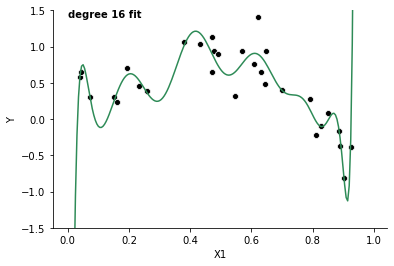

In [152]:
plot_poly_predictions(data, model)
# adjust the y-axis limits
plt.ylim(-1.5, 1.5);

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [159]:
model = polynomial_ridge_regression(data, deg=16, alpha=0.1)
print_coefficients(model)

Fitted polynomial for degree 16:
          16           15           14           13          12
-0.06684 x  - 0.07508 x  - 0.08437 x  - 0.09482 x  - 0.1065 x 
           11          10          9          8          7          6
 - 0.1196 x  - 0.1339 x  - 0.1493 x - 0.1653 x - 0.1808 x - 0.1935 x
           5          4          3           2
 - 0.1988 x - 0.1882 x - 0.1446 x - 0.03688 x + 0.1838 x + 0.5304


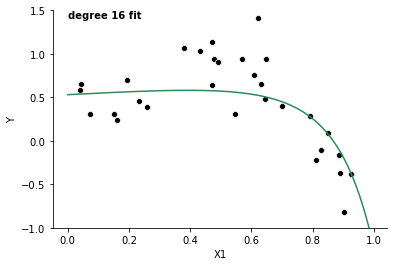

In [160]:
plot_poly_predictions(data, model)
# adjust the y-axis limits
plt.ylim(-1.0, 1.5);

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
Fitted polynomial for degree 16:
           16             15             14             13
2.365e+08 x  - 1.466e+09 x  + 3.913e+09 x  - 5.736e+09 x 
              12             11             10             9
 + 4.659e+09 x  - 1.311e+09 x  - 1.428e+09 x  + 2.039e+09 x
              8             7            6             5             4
 - 1.331e+09 x + 5.564e+08 x - 1.61e+08 x + 3.308e+07 x - 4.819e+06 x
              3             2
 + 4.834e+05 x - 3.104e+04 x + 1098 x - 15.06


lambda = 1.00e-10
Fitted polynomial for degree 16:
       16         15         14         13         12         11
896.7 x  - 674.4 x  - 851.6 x  - 254.8 x  + 454.2 x  + 745.9 x 
          10         9         8         7         6         5
 + 423.5 x  - 250.4 x - 665.2 x - 343.8 x + 391.8 x + 449.4 x
          4         3         2
 - 314.2 x - 74.04 x + 85.74 x - 15.9 x + 1.112


lambda = 1.00e-06
Fitted polynomial for degree 16:
       16         15          14         13         12

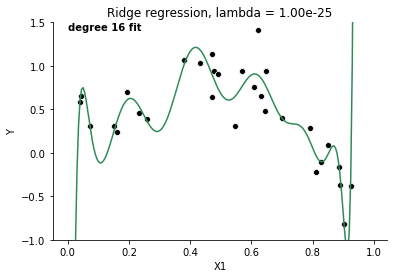

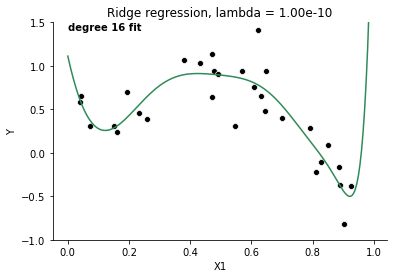

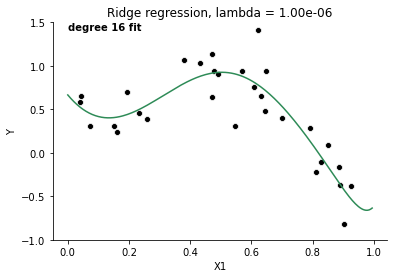

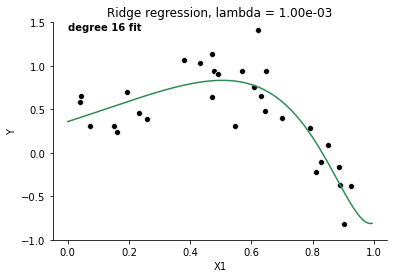

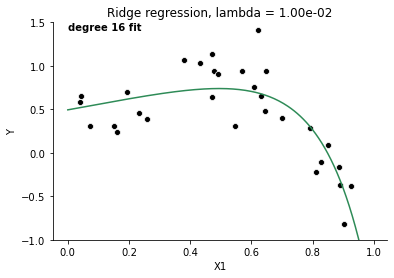

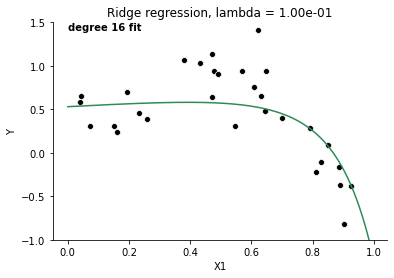

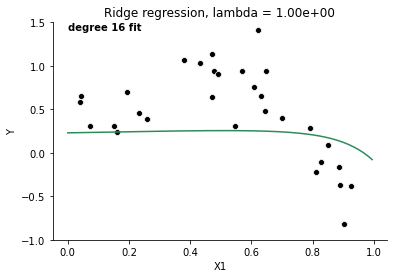

In [163]:
for alpha in [1e-25, 1e-10, 1e-6, 1e-3, 1e-2, 0.1, 1]:
    model = polynomial_ridge_regression(data, deg=16, alpha=alpha)
    print('lambda = %.2e' % alpha)
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data, model)
    plt.ylim(-1.0, 1.5)
    plt.title('Ridge regression, lambda = %.2e' % alpha)

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing lambda to minimise the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

Note that since statsmodels doesn't have a cross-validation functionality so we have to use sklearn.

In [164]:
# LOO cross validation -- return the average MSE
def loo(data, deg, alpha_values):
    # create polynomial features
    data = polynomial_features(data, deg)

    # create as many folds for cross-validation as there are data points
    num_folds = len(data)
    shuffled_data = shuffle(data, n_samples=num_folds)
    folds_iterator = KFold(n_splits=num_folds, random_state=98103)
    folds = [f for f in folds_iterator.split(shuffled_data)]

    alpha_mse = []
    min_mse = None
    best_alpha = []
    # for each value of alpha in the list...
    for alpha in alpha_values:
        next_mse = 0.0
        # for each fold...
        for train_indices, validation_indices in folds:
            # separate out X and Y for the training data
            train_X = shuffled_data.loc[train_indices].drop('Y', axis=1)
            train_X = sm.add_constant(train_X)
            train_y = shuffled_data.loc[train_indices]['Y']

            # train the model
            model = sm.OLS(train_y, train_X).fit_regularized(alpha=alpha, L1_wt=0.0)

            # separate out X and Y for the validation data
            val_X = shuffled_data.loc[validation_indices].drop('Y', axis=1)
            val_X = sm.add_constant(val_X, has_constant='add')
            val_y = shuffled_data.loc[validation_indices]['Y']

            # predict on the validation set
            y_pred = model.predict(val_X)
            # compute squared error
            next_mse += ((y_pred-val_y)**2).sum()
            # print("   Error so far:", next_mse)
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse / num_folds
        alpha_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_alpha = alpha
    
    return alpha_mse, best_alpha

Run LOO cross validation for "num" values of lambda, on a log scale

In [165]:
alpha_values = np.logspace(-10, 10, num=15)
alpha_mse, best_alpha = loo(data, 16, alpha_values)

Plot results of estimating LOO for each value of lambda

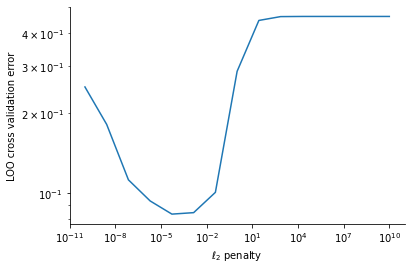

In [166]:
sns.lineplot(alpha_values, alpha_mse)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
sns.despine()

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [167]:
best_alpha

5.1794746792312125e-05

In [168]:
model = polynomial_ridge_regression(data, deg=16, alpha=best_alpha)
print_coefficients(model)

Fitted polynomial for degree 16:
        16          15          14          13          12          11
0.1038 x  + 0.2163 x  + 0.3391 x  + 0.4625 x  + 0.5702 x  + 0.6374 x 
           10          9          8          7         6         5
 + 0.6279 x  + 0.4919 x + 0.1675 x - 0.4067 x - 1.244 x - 2.184 x
          4         3         2
 - 2.611 x - 1.108 x + 3.337 x + 0.02169 x + 0.4176


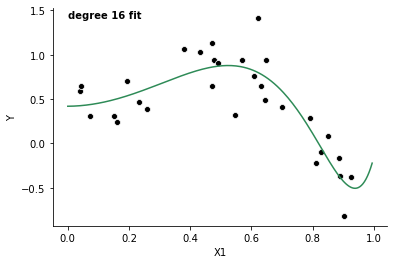

In [169]:
plot_poly_predictions(data, model)

# Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda (here called "alpha").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [170]:
def polynomial_lasso_regression(data, deg, alpha):
    X = polynomial_features(data, deg).drop('Y', axis=1)
    X = sm.add_constant(X)
    y = data['Y']
    
    # the term "alpha" is used instead of "lambda" in statsmodels (and sklearn btw)
    model = sm.OLS(y, X).fit_regularized(alpha=alpha, L1_wt=1.0)

    return model

## Explore the lasso solution as a function of a few different penalty strengths

l1_penalty = 1.000000e-10
number of nonzeros = 17
Fitted polynomial for degree 16:
        16          15          14          13          12          11
0.3279 x  + 0.2931 x  + 0.2552 x  + 0.2122 x  + 0.1621 x  + 0.1022 x 
            10           9          8          7          6         5
 + 0.02888 x  - 0.06215 x - 0.1766 x - 0.3216 x - 0.5035 x - 0.721 x
           4          3          2
 - 0.9362 x - 0.9861 x - 0.3716 x + 1.702 x + 0.3121


l1_penalty = 1.000000e-05
number of nonzeros = 14
Fitted polynomial for degree 16:
        14          13          12           10           9          8
0.3107 x  + 0.2648 x  + 0.3722 x  + 0.05981 x  - 0.01464 x - 0.1344 x
           7          6          5          4          3          2
 - 0.2855 x - 0.4748 x - 0.7015 x - 0.9283 x - 0.9922 x - 0.3881 x + 1.681 x + 0.3194


l1_penalty = 1.000000e-02
number of nonzeros = 5
Fitted polynomial for degree 16:
         6          5         4
-0.1983 x - 0.8757 x - 1.049 x + 0.5306 x + 0.5383




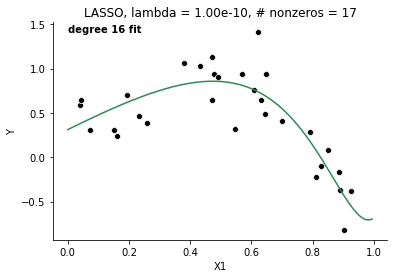

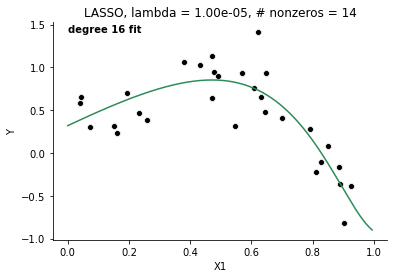

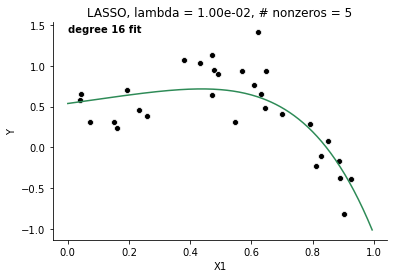

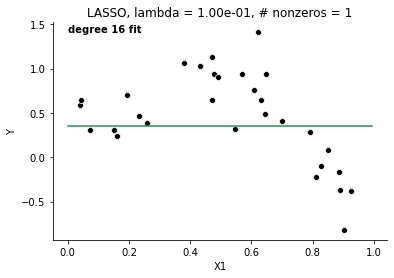

In [179]:
for alpha in [1e-10, 1e-5, 1e-2, 0.1]:
    model = polynomial_lasso_regression(data, deg=16, alpha=alpha)
    print('l1_penalty = %e' % alpha)
    print('number of nonzeros = %d' % (np.count_nonzero(model.params)))
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (alpha, np.count_nonzero(model.params)))

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.